# Another MNIST fashion DNN

This is my exploration of the MNIST fashion dataset. The dataset introduces a bit more trickery than the original MNIST dataset, with more room for improvement.

The dataset consists of 70000 pictures of 10 different types of clothing. I'm going to build two fully connected dense networks, one with dropout and one without, to see which does a better job at image classification.

First we'll import some packages we'll need, then the images and their labels.

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from random import shuffle

In [5]:
train = pd.read_csv('fashionmnist/fashion-mnist_train.csv')
train_x = np.array(train.drop('label', axis=1))
train_x = train_x.reshape(train_x.shape[0], 28, 28)
train_y = np.array(train['label'])

test = pd.read_csv('fashionmnist/fashion-mnist_test.csv')
test_x = np.array(test.drop('label', axis=1))
test_x = test_x.reshape(test_x.shape[0], 28, 28)
test_y = np.array(test['label'])

print("Shape of training images: ", train_x.shape)
print("Shape of test images: ", test_x.shape)

Shape of training images:  (60000, 28, 28)
Shape of test images:  (10000, 28, 28)


Each image is 28x28 pixels, in greyscale, with a maximum pixel value of 255. The higher the value, the darker the pixel.

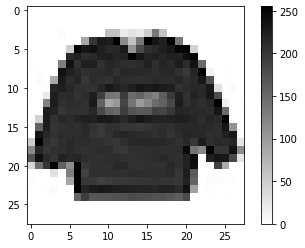

In [6]:
plt.figure()
plt.imshow(train_x[0], plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

## Preprocessing

First we need to normalize the images, reducing their pixel values to between 0 and 1. We do this by dividing all pixels by the maximum value of 255.

In [7]:
print("Maximum pixel value before normalization: ", train_x.max())
train_x = train_x / 255
test_x = test_x / 255
print("Maximum pixel value after normalization: ", train_x.max())

Maximum pixel value before normalization:  255
Maximum pixel value after normalization:  1.0


Since each label is represented in our dataset by an integer from 0-9, we'll also create a list of labels to give more intuitive meaning to each class.

In [8]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Let's take a look at some more of the images to see what we're working with. 

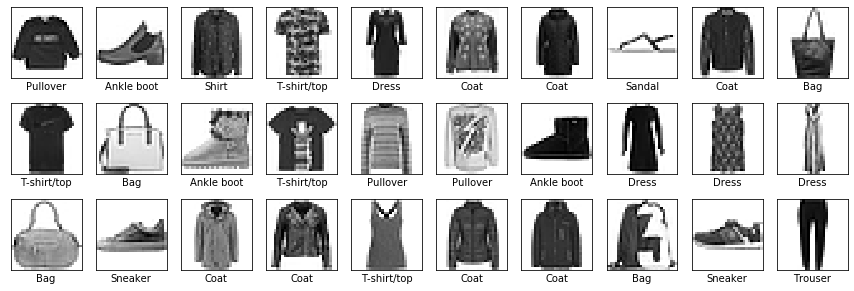

In [9]:
plt.figure(figsize=(15,5))

for i in range(0, 30):
    plt.subplot(3, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_x[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_y[i]])
    
plt.show()

Not the greatest resolution pictures by any means, but they should be clear enough for a neural network to learn some of their differentiating qualities. 

It's important to always shuffle our data, so our model doesn't catch on to any ordering. This would be a major issue if our data was sorted. If all the initial images our model is trained on are ankle boots, it will quickly learn to guess that all images are ankle boots, and will take longer to learn otherwise. 

Another potential issue would arise if our data was unbalanced. If 90% of the images were of ankle boots, our model could quickly learn to always guess ankle boot and achieve a 90% accuracy rate, instead of actually learning features from the images. Again, this dataset is balanced as well as shuffled, but it's important to keep in mind. We'll verify that the data is balanced anyway, then shuffle it for good measure.

In [10]:
print(np.unique(train_y, return_counts=True))
print(np.unique(test_y, return_counts=True))

train_shuffled = list(zip(train_y, train_x))
shuffle(train_shuffled)
train_y = np.array([label for label, image in train_shuffled])
train_x = np.array([image for label, image in train_shuffled])

test_shuffled = list(zip(test_y, test_x))
shuffle(test_shuffled)
test_y = np.array([label for label, image in test_shuffled])
test_x = np.array([image for label, image in test_shuffled])

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))


## Building the model

Now we can start building a few different models and see how they perform. We'll start with a basic neural network with one fully connected hidden layer. 

The first layer we need to add flattens our image data into 1 dimension, which we can pass forward. 

Our next layer is the fully connected hidden layer, labeled as a Dense layer in tensorflow.

Our final layer is another Dense function with one output for each of our labels. The softmax activation function takes the output of the previous layer and transforms them into normalized probabilities for each label.

In [11]:
model = keras.Sequential()

model.add(keras.layers.Flatten(input_shape=(28, 28)))
model.add(keras.layers.Dense(64, activation=tf.nn.relu))
model.add(keras.layers.Dense(10, activation=tf.nn.softmax))

In the next step we decide how we want the model to optimize our learning, calculate our loss, and which metrics we want to keep track of.

In [12]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy']
             )

## Running the model

Now we can finally run our model and see how it performs. We'll run for a maximum of 50 epochs, but stop training if we our loss stops decreasing for the last 10 epochs.

In [13]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

model.fit(train_x, train_y, 
          validation_data=(test_x, test_y), 
          epochs=50,
          callbacks=[early_stop_callback])

Epoch 1/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5173 - accuracy: 0.8194 - val_loss: 0.4035 - val_accuracy: 0.8608
Epoch 2/50
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3940 - accuracy: 0.8593 - val_loss: 0.3676 - val_accuracy: 0.8707
Epoch 3/50
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3550 - accuracy: 0.8732 - val_loss: 0.3560 - val_accuracy: 0.8748
Epoch 4/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3319 - accuracy: 0.8805 - val_loss: 0.3537 - val_accuracy: 0.8748
Epoch 5/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3139 - accuracy: 0.8854 - val_loss: 0.3219 - val_accuracy: 0.8825
Epoch 6/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2996 - accuracy: 0.8892 - val_loss: 0.3358 - val_accuracy: 0.8793
Epoch 7/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2891 - accuracy: 0.8942 - val_loss: 0.3347 - val_accuracy:

We can see that the model's accuracy on the training data keeps rising, but the accuracy on the validation data reaches a maximum of about 89% pretty early on. This indicates that the model learns features that generalize fairly quickly, but then starts overfitting on the training data. 

We might be able to slow down the overfitting on the training data by adding a dropout layer. The dropout layers in keras randomly sets a fraction of inputs to 0. This helps force our model to pick up on actual features, as opposed to just memorizing the data. The training process typically takes longer with dropouts, but it ensures that the loss on the training set, and the testing set don't diverge as quickly.

## Model with dropout

In [16]:
model = keras.Sequential()

model.add(keras.layers.Flatten(input_shape=(28, 28)))
model.add(keras.layers.Dense(128, activation=tf.nn.relu))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(128, activation=tf.nn.relu))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(10, activation=tf.nn.softmax))

In [17]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy']
             )

Since the model will take longer to train, we will give it more epochs and a more generous patience cutoff.

In [18]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

model.fit(train_x, train_y, 
          validation_data=(test_x, test_y), 
          epochs=150,
          callbacks=[early_stop_callback])

Epoch 1/150
1875/1875 [==============================] - 5s 3ms/step - loss: 0.6769 - accuracy: 0.7594 - val_loss: 0.4974 - val_accuracy: 0.8208
Epoch 2/150
1875/1875 [==============================] - 5s 2ms/step - loss: 0.5443 - accuracy: 0.8058 - val_loss: 0.4496 - val_accuracy: 0.8381
Epoch 3/150
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5099 - accuracy: 0.8181 - val_loss: 0.4102 - val_accuracy: 0.8485
Epoch 4/150
1875/1875 [==============================] - 5s 2ms/step - loss: 0.4922 - accuracy: 0.8225 - val_loss: 0.4322 - val_accuracy: 0.8358
Epoch 5/150
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4726 - accuracy: 0.8308 - val_loss: 0.3934 - val_accuracy: 0.8596
Epoch 6/150
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4636 - accuracy: 0.8324 - val_loss: 0.3833 - val_accuracy: 0.8618
Epoch 7/150
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4538 - accuracy: 0.8394 - val_loss: 0.3723 - val_ac

1875/1875 [==============================] - 4s 2ms/step - loss: 0.3505 - accuracy: 0.8735 - val_loss: 0.3253 - val_accuracy: 0.8824
Epoch 58/150
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3464 - accuracy: 0.8760 - val_loss: 0.3181 - val_accuracy: 0.8864
Epoch 59/150
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3469 - accuracy: 0.8743 - val_loss: 0.3161 - val_accuracy: 0.8855
Epoch 60/150
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3500 - accuracy: 0.8737 - val_loss: 0.3194 - val_accuracy: 0.8828
Epoch 61/150
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3424 - accuracy: 0.8759 - val_loss: 0.3129 - val_accuracy: 0.8859
Epoch 62/150
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3454 - accuracy: 0.8742 - val_loss: 0.3183 - val_accuracy: 0.8849
Epoch 63/150
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3418 - accuracy: 0.8759 - val_loss: 0.3222 - val_accuracy

In [19]:
test_loss, test_acc = model.evaluate(test_x, test_y)
print(test_loss, test_acc)

313/313 [==============================] - 0s 2ms/step - loss: 0.3084 - accuracy: 0.8877
0.3084047734737396 0.8877000212669373


It doesn't look like including dropout actually has much of an effect in this case. The model even does slightly worse than the simple network with one hidden layer.

## Analysis

Let's take a look at some of the images our model had a hard time with. We can also see the probabilities it attributed to each label.

In [21]:
prediction_probabilities = model.predict(test_x)
predictions = pd.Series([np.argmax(row) for row in prediction_probabilities], name='prediction')
true_labels = pd.Series(test_y, name='label')
predictions_vs_labels = pd.concat([predictions, true_labels], axis=1)
mistakes = predictions_vs_labels[predictions_vs_labels['prediction'] != predictions_vs_labels['label']]

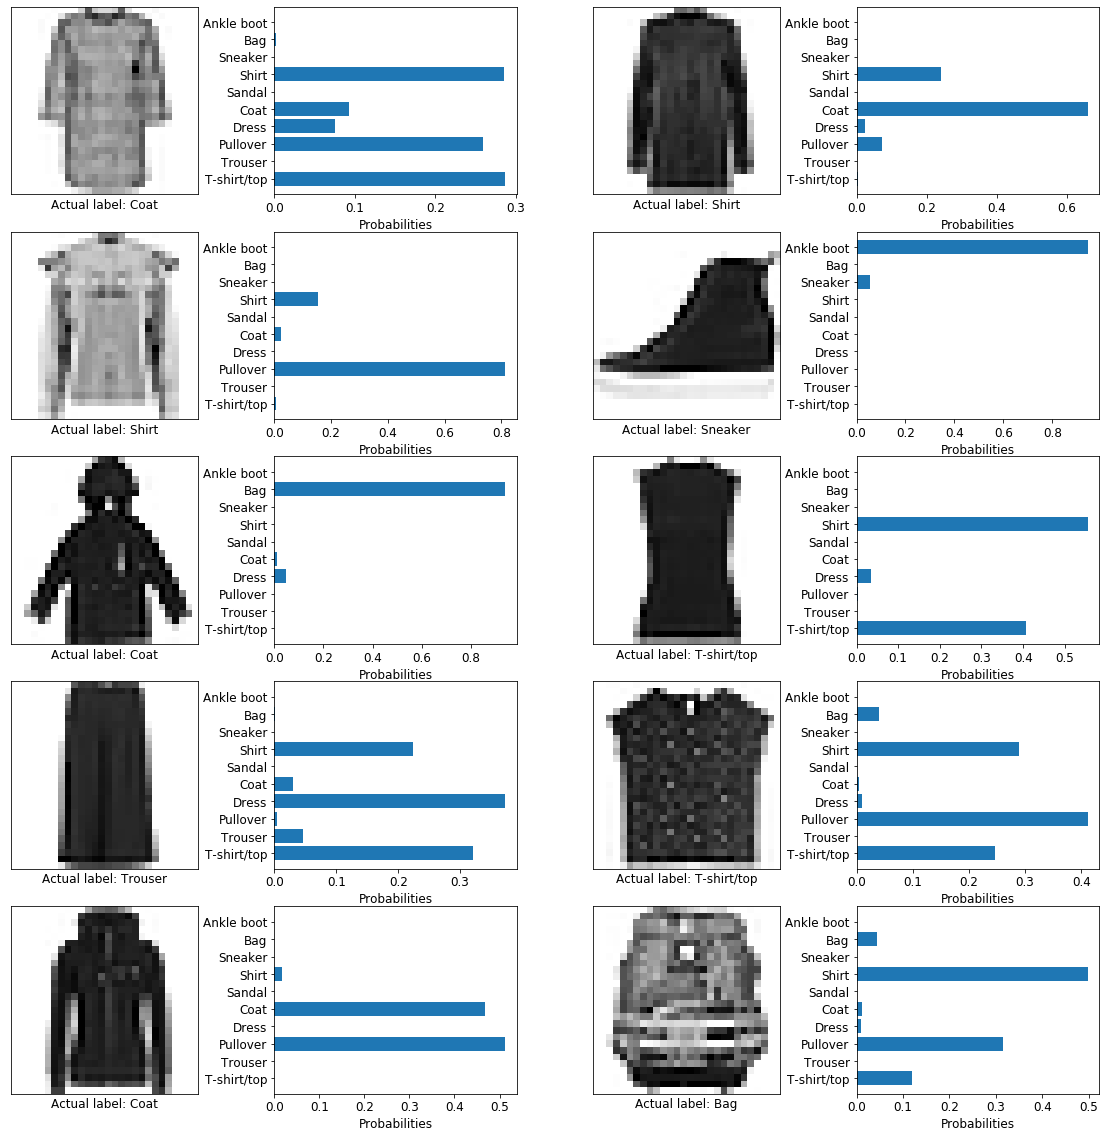

In [23]:
plt.figure(figsize=(20, 20))
plt.rcParams.update({'font.size': 12})

for i in range(0, 20, 2):
    
    plt.subplot(5, 4, i+1)
    plt.imshow(test_x[mistakes.index[i]], cmap=plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f'Actual label: {class_names[mistakes.iloc[i]["label"]]}')
#     plt.xlabel(f'Actual label: {class_names[test_x[mistakes.index[i]]]}')
    
    plt.subplot(5, 4, i+2)
    mistake_prob = prediction_probabilities[mistakes.index[i]]
    plt.barh(y=np.linspace(start=0, stop=9, num=10), tick_label=class_names, width=mistake_prob)
    plt.xlabel('Probabilities')

Most of the mistakes are pretty understandable, and consistent. Our network makes a lot of the same mistakes that I would  make in trying to assign labels to these pictures. In particular there seems to be a lot of confusion between shirts, t-shirts, and pullovers. 

We can actually see which labels are mixed up most often with a confusion matrix that compares all of our predictions with the true labels.

In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10, 10))
confusion_matrix = confusion_matrix(true_labels, predictions)
ax = sns.heatmap(confusion_matrix, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()


ModuleNotFoundError: No module named 'sklearn'

For what amounts to just a bunch of matrix multiplication, this neural network does about as good of a job identifying poorly pixelated articles of clothing as I would. We can improve a bit more by swapping out our fully connected dense network for a convolutional network, but I'll save that for another notebook. This was just meant as an initial exploration of image classification with tensorflow. 